# Capstone Project: Capstone Project: German Traffic Sign Recognition Benchmark
# AWS Machine Learning Engineer Nanodegree

In [3]:
!pip install smdebug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 4.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 1.4 MB/s eta 0:00:00:00:01


In [ ]:
import sagemaker
import boto3
import os
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorchModel
import numpy as np


## Dataset
The chosen dataset is the one from the German Traffic Sign Recognition Benchmark. It contains images of different traffic signs.

In [67]:
classes_distinct = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [68]:
classes_combined = {0:"Speed limit signs",
                    1:"Other prohibitory signs",
                    2:"Derestriction signs",
                    3:"Mandatory signs",
                    4:"Danger signs",
                    5:"Unique signs"
}

In [71]:
distinct_combined_mapping = { 0:0,
            1:0, 
            2:0, 
            3:0, 
            4:0, 
            5:0, 
            6:2, 
            7:0, 
            8:0, 
            9:1, 
            10:1, 
            11:4, 
            12:5, 
            13:5, 
            14:5, 
            15:5, 
            16:1, 
            17:1, 
            18:4, 
            19:4, 
            20:4, 
            21:4, 
            22:4, 
            23:4, 
            24:4, 
            25:4, 
            26:4, 
            27:4, 
            28:4, 
            29:4, 
            30:4,
            31:4, 
            32:2, 
            33:3, 
            34:3, 
            35:3, 
            36:3, 
            37:3, 
            38:3, 
            39:3, 
            40:3, 
            41:2, 
            42:2}

In [109]:
# copy all images to one folder
# split up train and validation + csv
import os
import shutil
from glob import glob
import random
import pandas as pd

# make splitting into training and validation images reproducible by setting seed
random.seed(42)

def move_img_from_subfolders(data_path):
    # Collect files.
    files = glob(os.path.join(data_path, "**"), recursive=True)

    # Move all files.
    for f in files:
        if os.path.isfile(f):
            base = os.path.basename(f)
            shutil.move(f, os.path.join(data_path, base))

move_img_from_subfolders("./TrafficSignImages/Train")
move_img_from_subfolders("./TrafficSignImages/Test")

# Split training data into training and validation
train_images = glob(os.path.join("./TrafficSignImages/Train", "**"))

training_ratio = 0.8
n_train_images = int(len(train_images)*training_ratio)
n_val_images = len(train_images) - n_train_images

random.shuffle(train_images)

val_images = train_images[0:n_val_images]
val_image_names = [os.path.basename(val_image) for val_image in val_images]
train_images = train_images[n_val_images:]
train_image_names = [os.path.basename(train_image) for train_image in train_images]

val_path = ("./TrafficSignImages/Val")
if not os.path.isdir(val_path):
    os.makedirs(val_path)

for f in val_images:
    if os.path.isfile(f):
        base = os.path.basename(f)
        shutil.move(f, os.path.join(val_path, base))

In [ ]:
# create and edit ground truths
training_ground_truth_distinct = pd.read_csv("./TrafficSignImages/Train.csv")
training_ground_truth_distinct["Path"] = training_ground_truth_distinct["Path"] .apply(lambda x: os.path.basename(x))

validation_ground_truth_distinct = training_ground_truth_distinct.loc[training_ground_truth_distinct['Path'].isin(val_image_names)]
validation_ground_truth_distinct.to_csv("./TrafficSignImages/Val/gt_43.csv")

training_ground_truth_distinct = training_ground_truth_distinct.loc[training_ground_truth_distinct['Path'].isin(train_image_names)]
training_ground_truth_distinct.to_csv("./TrafficSignImages/Train/gt_43.csv")

# move testing ground truth
testing_ground_truth_distinct = pd.read_csv("./TrafficSignImages/Test.csv")
testing_ground_truth_distinct["Path"] = testing_ground_truth_distinct["Path"] .apply(lambda x: os.path.basename(x))
testing_ground_truth_distinct.to_csv("./TrafficSignImages/Test/gt_43.csv")

training_ground_truth_combined = training_ground_truth_distinct.copy()
training_ground_truth_combined["ClassId"] = training_ground_truth_combined["ClassId"] .apply(lambda x: distinct_combined_mapping[x])
training_ground_truth_combined.to_csv("./TrafficSignImages/Train/gt_6.csv")

validation_ground_truth_combined =validation_ground_truth_distinct.copy()
validation_ground_truth_combined["ClassId"] = validation_ground_truth_combined["ClassId"] .apply(lambda x: distinct_combined_mapping[x])
validation_ground_truth_combined.to_csv("./TrafficSignImages/Val/gt_6.csv")

testing_ground_truth_combined = testing_ground_truth_distinct.copy()
testing_ground_truth_combined["ClassId"] = testing_ground_truth_combined["ClassId"] .apply(lambda x: distinct_combined_mapping[x])
testing_ground_truth_combined.to_csv("./TrafficSignImages/Test/gt_6.csv")

In [113]:
%%capture
#upload the data to S3
session = sagemaker.session.Session()

bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./TrafficSignImages/Train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./TrafficSignImages/Test s3://${DEFAULT_S3_BUCKET}/test/
!aws s3 sync ./TrafficSignImages/Val s3://${DEFAULT_S3_BUCKET}/valid/

In [127]:
data_channels = {
    "train" : f"s3://{bucket}/train/",
    "valid" : f"s3://{bucket}/valid/",
    "test" : f"s3://{bucket}/test/"
}

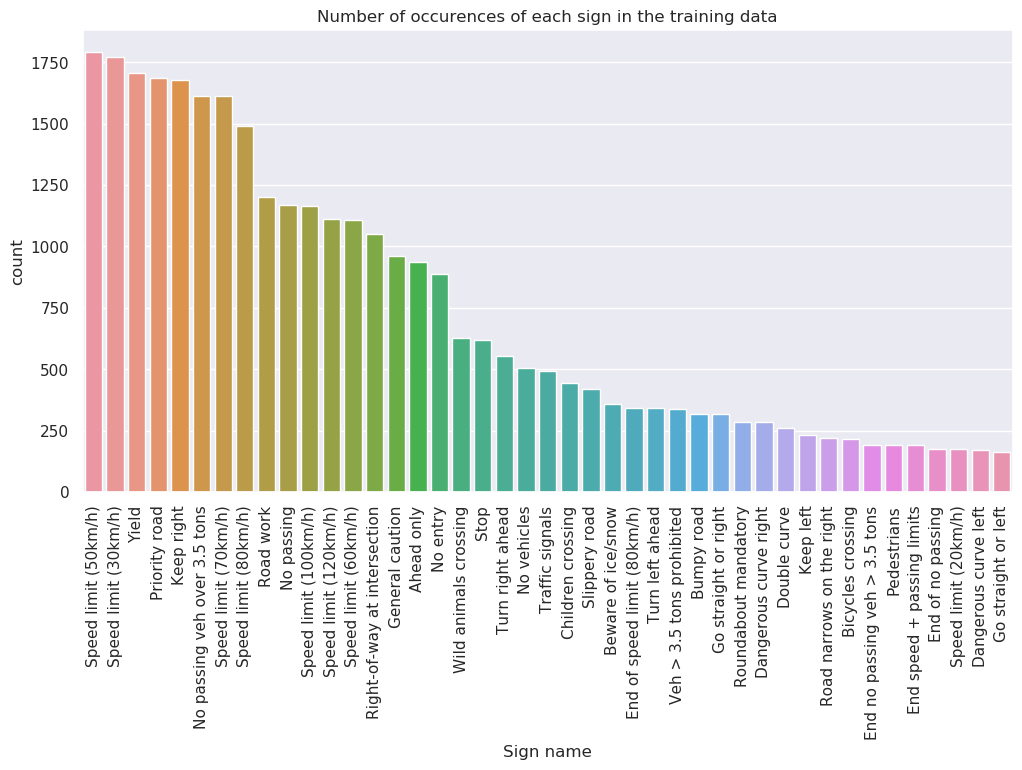

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.countplot(training_ground_truth_distinct["ClassId"] .apply(lambda x: classes_distinct[x]), order=training_ground_truth_distinct["ClassId"] .apply(lambda x: classes_distinct[x]).value_counts().index)
plt.xticks(rotation=90)
plt.xlabel("Sign name")
plt.title("Number of occurences of each sign in the training data")
plt.savefig("training_classes_distinct.png")
plt.show()

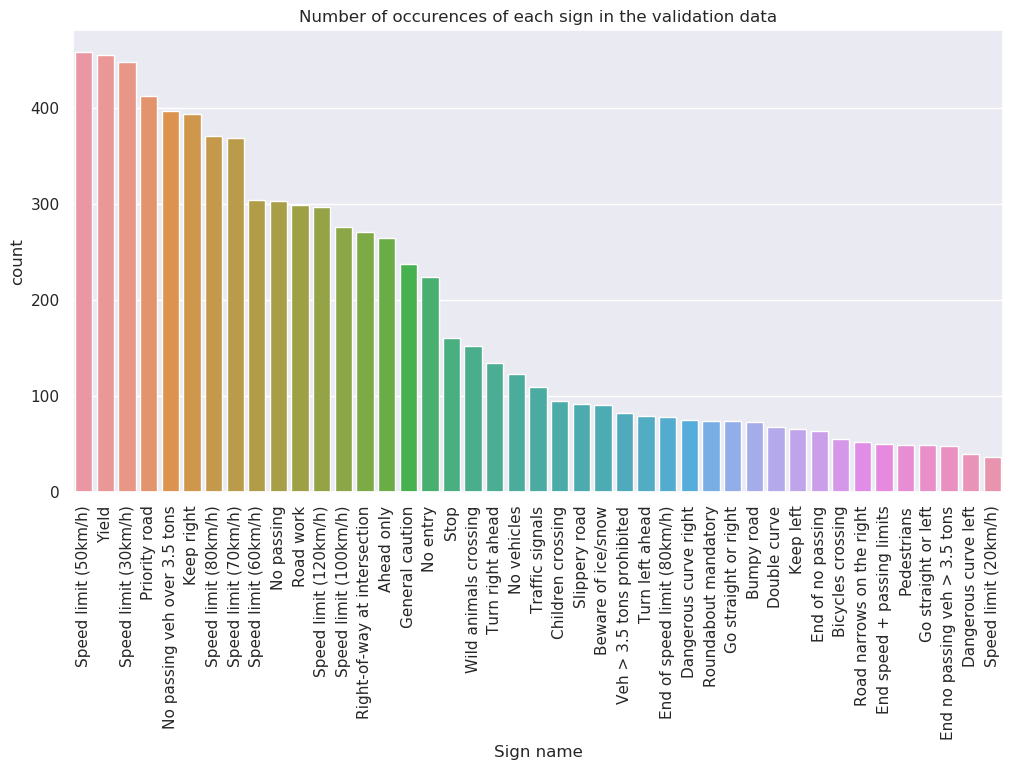

In [118]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.countplot(validation_ground_truth_distinct["ClassId"] .apply(lambda x: classes_distinct[x]), order= validation_ground_truth_distinct["ClassId"] .apply(lambda x: classes_distinct[x]).value_counts().index)
plt.xticks(rotation=90)
plt.xlabel("Sign name")
plt.title("Number of occurences of each sign in the validation data")
plt.savefig("val_classes_distinct.png")
plt.show()

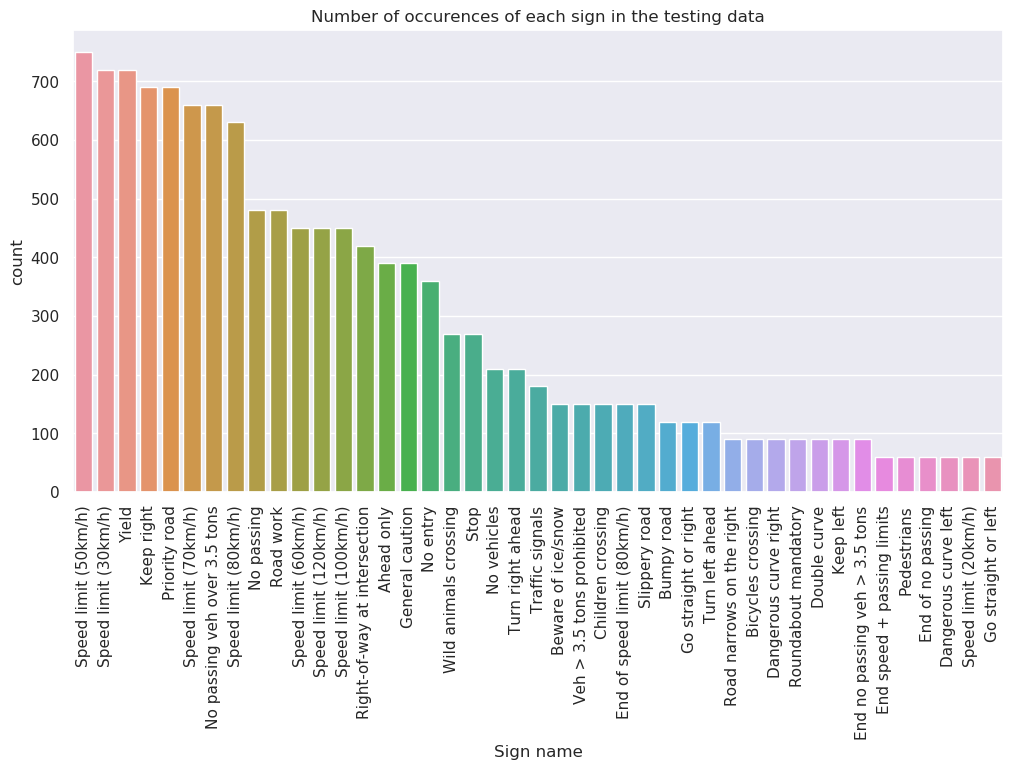

In [119]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.countplot(testing_ground_truth_distinct["ClassId"] .apply(lambda x: classes_distinct[x]), order=testing_ground_truth_distinct["ClassId"] .apply(lambda x: classes_distinct[x]).value_counts().index)
plt.xticks(rotation=90)
plt.xlabel("Sign name")
plt.title("Number of occurences of each sign in the testing data")
plt.savefig("testing_classes_distinct.png")
plt.show()

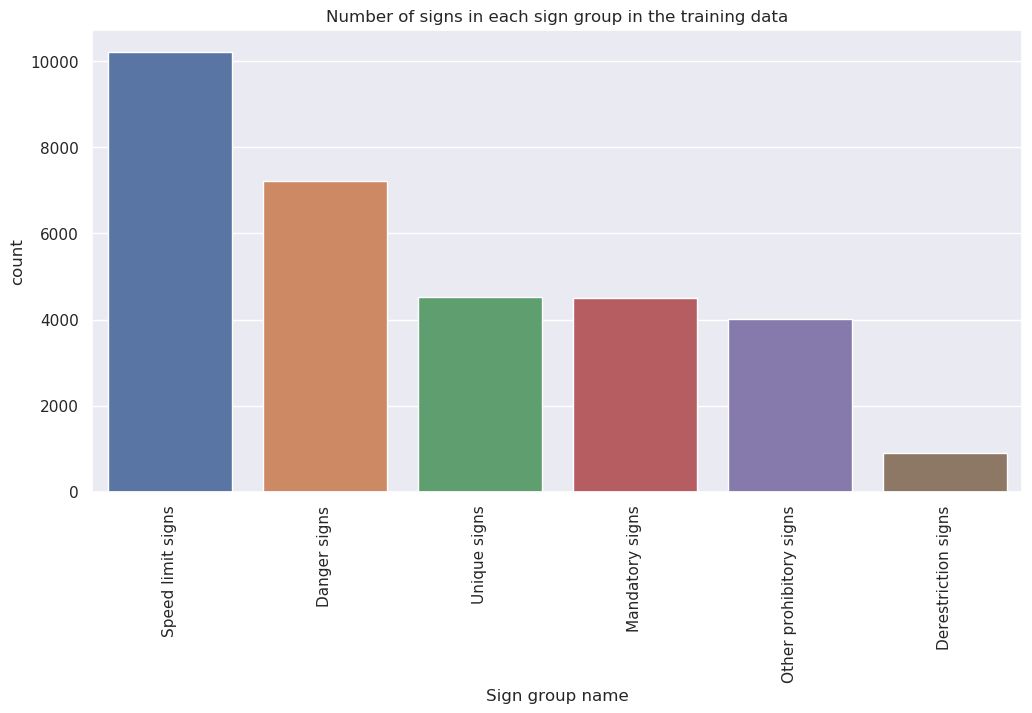

In [120]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.countplot(training_ground_truth_combined["ClassId"] .apply(lambda x: classes_combined[x]), order=training_ground_truth_combined["ClassId"] .apply(lambda x: classes_combined[x]).value_counts().index)
plt.xticks(rotation=90)
plt.xlabel("Sign group name")
plt.title("Number of signs in each sign group in the training data")
plt.savefig("training_classes_combined.png")
plt.show()

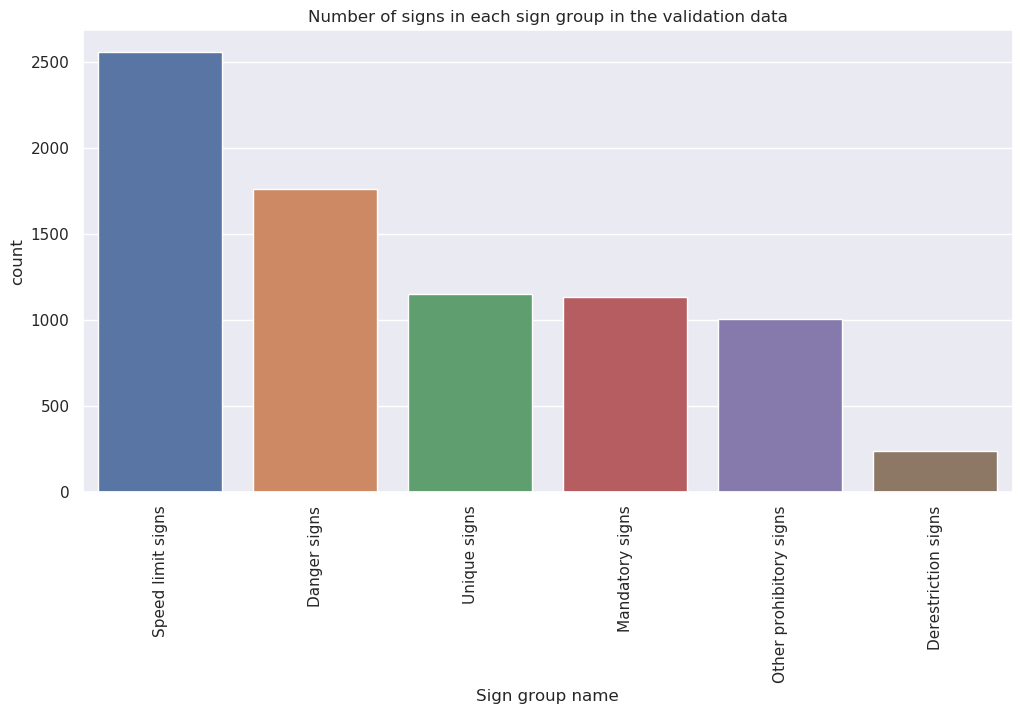

In [121]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.countplot(validation_ground_truth_combined["ClassId"] .apply(lambda x: classes_combined[x]), order=validation_ground_truth_combined["ClassId"] .apply(lambda x: classes_combined[x]).value_counts().index)
plt.xticks(rotation=90)
plt.xlabel("Sign group name")
plt.title("Number of signs in each sign group in the validation data")
plt.savefig("val_classes_combined.png")
plt.show()

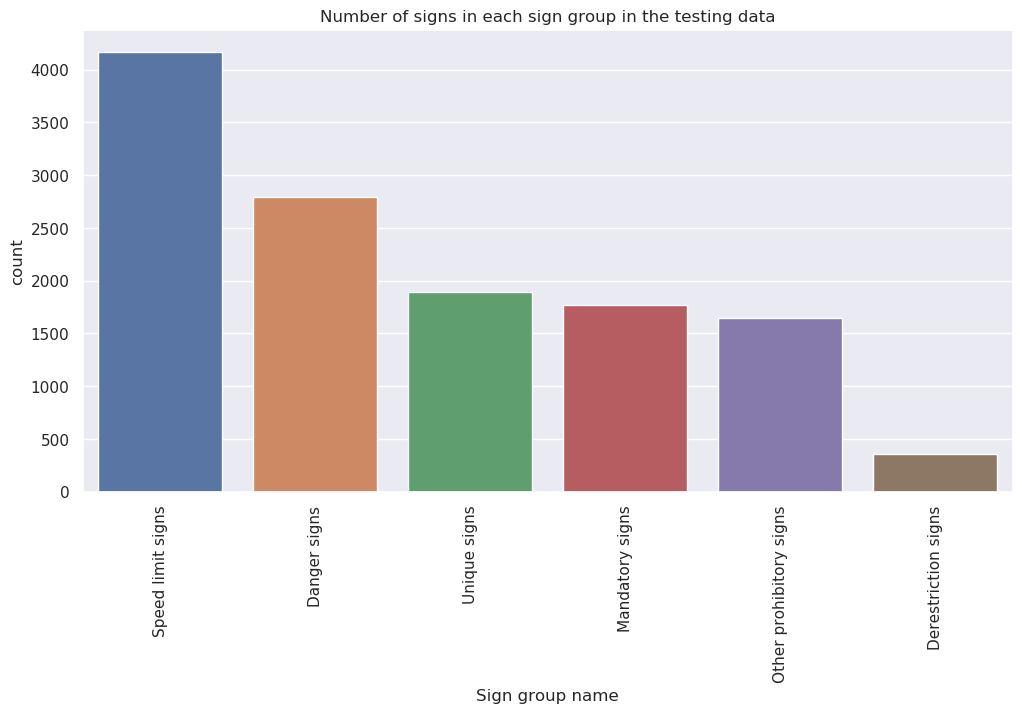

In [122]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.countplot(testing_ground_truth_combined["ClassId"] .apply(lambda x: classes_combined[x]), order=testing_ground_truth_combined["ClassId"] .apply(lambda x: classes_combined[x]).value_counts().index)
plt.xticks(rotation=90)
plt.xlabel("Sign group name")
plt.title("Number of signs in each sign group in the testing data")
plt.savefig("testing_classes_combined.png")
plt.show()

## Testing Functions

In [225]:
# define functions for later calculations of metrics
from sklearn.metrics import accuracy_score, confusion_matrix

def calc_accuracy(ground_truth, calc_label):
    return accuracy_score(ground_truth, calc_label)

def calc_acc_per_class(ground_truth, calc_label):
    matrix = confusion_matrix(ground_truth, calc_label)
    return matrix.diagonal()/matrix.sum(axis=1)
    

In [100]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

## Baseline models

Create baseline models which we can use for comparison to our later models.

In [123]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [124]:
# set default hyperparameters

default_hyperparameters_combined={'batch-size': 16,
                      'lr': 0.001, 'num-epochs': 1, 'num-of-classes': 6}

default_hyperparameters_distinct={'batch-size': 16,
                      'lr': 0.001, 'num-epochs': 1, 'num-of-classes': 43}

In [ ]:
estimator_base_combined = PyTorch(
    entry_point="train_model.py",
    base_job_name="trafficSignRecognitionBaseCombined",
    role=sagemaker.get_execution_role(),
    instance_count=2,
    instance_type="ml.m5.xlarge",
    hyperparameters=default_hyperparameters_combined,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    profiler_config = profiler_config,
    debugger_hook_config=hook_config,
)

estimator_base_combined.fit(data_channels, wait=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: trafficSignRecogni

2023-04-15 14:42:08 Starting - Starting the training job...
2023-04-15 14:42:46 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2023-04-15 14:43:12 Downloading - Downloading input data............
2023-04-15 14:45:09 Training - Downloading the training image....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-15 14:45:51,877 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-15 14:45:51,879 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-15 14:45:51,888 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-15 14:45:51,890 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-15 14:45:52,055 sagemaker-training-toolk

In [129]:
estimator_base_distinct = PyTorch(
    entry_point="train_model.py",
    base_job_name="trafficSignRecognitionBaseDistinct",
    role=sagemaker.get_execution_role(),
    instance_count=2,
    instance_type="ml.m5.xlarge",
    hyperparameters=default_hyperparameters_distinct,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    profiler_config = profiler_config,
    debugger_hook_config=hook_config,
)

estimator_base_distinct.fit(data_channels, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: trafficSignRecognitionBaseDistinct-2023-04-15-16-01-35-262


2023-04-15 16:01:40 Starting - Starting the training job...
2023-04-15 16:02:08 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2023-04-15 16:02:46 Downloading - Downloading input data...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-15 16:04:27,950 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-15 16:04:27,953 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-15 16:04:27,961 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-15 16:04:27,964 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-15 16:04:28,110 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-

In [130]:
job_name_base_combined = estimator_base_combined.latest_training_job.name
client_base_combined = estimator_base_combined.sagemaker_session.sagemaker_client
description_base_combined = client_base_combined.describe_training_job(TrainingJobName=estimator_base_combined.latest_training_job.name)

In [131]:
job_name_base_distinct = estimator_base_distinct.latest_training_job.name
client_base_distinct = estimator_base_distinct.sagemaker_session.sagemaker_client
description_base_distinct = client_base_distinct.describe_training_job(TrainingJobName=estimator_base_distinct.latest_training_job.name)

In [156]:
estimator_base_combined_path = estimator_base_combined.model_data

In [157]:
estimator_base_distinct_path = estimator_base_distinct.model_data

[2023-04-15 17:20:29.234 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-15 17:20:29.253 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionBaseCombined-2023-04-15-14-42-07-185/debug-output
[2023-04-15 17:20:37.259 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-04-15 17:20:38.284 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


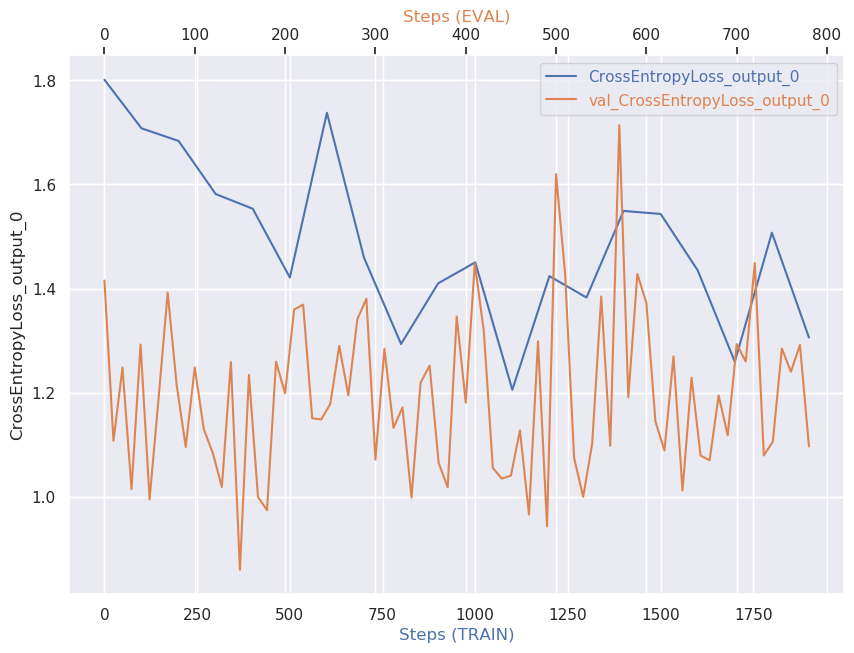

In [134]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator_base_combined.latest_job_debugger_artifacts_path())

plot_tensor(trial, "CrossEntropyLoss_output_0")

[2023-04-15 17:20:49.482 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionBaseDistinct-2023-04-15-16-01-35-262/debug-output
[2023-04-15 17:20:49.739 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4704 more expected)', IncompleteRead(0 bytes read, 4704 more expected)) while reading s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionBaseDistinct-2023-04-15-16-01-35-262/debug-output/index/000000001/000000001000_worker_0.json . Will retry now
[2023-04-15 17:20:52.271 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-04-15 17:20:53.293 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 I

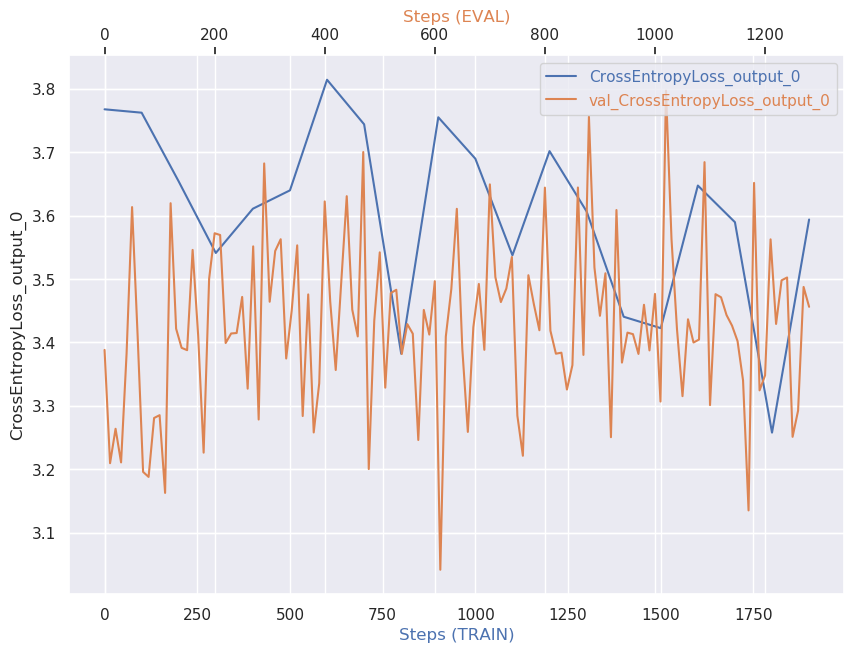

In [135]:
trial = create_trial(estimator_base_distinct.latest_job_debugger_artifacts_path())

plot_tensor(trial, "CrossEntropyLoss_output_0")

In [140]:
rule_output_path = estimator_base_combined.output_path + estimator_base_combined.latest_training_job.job_name + "/rule-output"

! aws s3 cp {rule_output_path} ./base/combined/ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name_base_combined = [
    rule["RuleConfigurationName"]
    for rule in estimator_base_combined.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

download: s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionBaseCombined-2023-04-15-14-42-07-185/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to base/combined/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionBaseCombined-2023-04-15-14-42-07-185/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to base/combined/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionBaseCombined-2023-04-15-14-42-07-185/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to base/combined/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionBaseCombined-2023-04-15-14-42-07-185/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to base/co

In [141]:
rule_output_path = estimator_base_distinct.output_path + estimator_base_distinct.latest_training_job.job_name + "/rule-output"

! aws s3 cp {rule_output_path} ./base/distinct/ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name_base_distinct= [
    rule["RuleConfigurationName"]
    for rule in estimator_base_distinct.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

download: s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionBaseDistinct-2023-04-15-16-01-35-262/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to base/distinct/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionBaseDistinct-2023-04-15-16-01-35-262/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to base/distinct/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionBaseDistinct-2023-04-15-16-01-35-262/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to base/distinct/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionBaseDistinct-2023-04-15-16-01-35-262/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to base/distinct/P

In [142]:
import shutil
shutil.make_archive("./base/combined", "zip", "ProfilerReport")

'/root/base/combined.zip'

In [143]:
shutil.make_archive("./base/distinct", "zip", "ProfilerReport")

'/root/base/distinct.zip'

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [144]:
#Declare  HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16, 32, 64, 128]),
    "num-epochs": CategoricalParameter([1, 3, 6])
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [145]:

estimator_combined = PyTorch(
    entry_point="hpo_combined.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    
)

tuner_combined = HyperparameterTuner(
    estimator_combined,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
    early_stopping_type="Auto"
)

In [146]:
estimator_distinct = PyTorch(
    entry_point="hpo_distinct.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
)

tuner_distinct = HyperparameterTuner(
    estimator_distinct,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
    early_stopping_type="Auto"
)

In [148]:
tuner_combined.fit(data_channels, wait = True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230415-1737


..................................................................................................................................................................................................................................................................................................................................................................................................!


In [149]:
tuner_distinct.fit(data_channels, wait = True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230415-1810


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [150]:
# Get the best estimators and the best HPs

best_estimator_combined = tuner_combined.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator_combined.hyperparameters()


2023-04-15 18:07:43 Starting - Preparing the instances for training
2023-04-15 18:07:43 Downloading - Downloading input data
2023-04-15 18:07:43 Training - Training image download completed. Training in progress.
2023-04-15 18:07:43 Uploading - Uploading generated training model
2023-04-15 18:07:43 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"16"',
 'lr': '0.05531851543413778',
 'num-epochs': '"3"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-04-15-17-37-26-438"',
 'sagemaker_program': '"hpo_combined.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-478238033619/pytorch-training-2023-04-15-17-37-26-438/source/sourcedir.tar.gz"'}

In [151]:
# Get the best estimators and the best HPs

best_estimator_distinct = tuner_distinct.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator_distinct.hyperparameters()


2023-04-15 18:35:20 Starting - Preparing the instances for training
2023-04-15 18:35:20 Downloading - Downloading input data
2023-04-15 18:35:20 Training - Training image download completed. Training in progress.
2023-04-15 18:35:20 Uploading - Uploading generated training model
2023-04-15 18:35:20 Completed - Resource reused by training job: pytorch-training-230415-1810-003-2a882652


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"128"',
 'lr': '0.04731508411129931',
 'num-epochs': '"6"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-04-15-18-10-29-784"',
 'sagemaker_program': '"hpo_distinct.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-478238033619/pytorch-training-2023-04-15-18-10-29-784/source/sourcedir.tar.gz"'}

In [154]:
best_hyperparameters_combined={'batch-size': int(best_estimator_combined.hyperparameters()['batch-size'].replace('"', "")),
                      'lr': best_estimator_combined.hyperparameters()['lr'], 'num-epochs': int(best_estimator_combined.hyperparameters()['num-epochs'].replace('"', "")), 'num-of-classes':6}

best_hyperparameters_distinct={'batch-size': int(best_estimator_distinct.hyperparameters()['batch-size'].replace('"', "")),
                      'lr': best_estimator_distinct.hyperparameters()['lr'], 'num-epochs': int(best_estimator_distinct.hyperparameters()['num-epochs'].replace('"', "")), 'num-of-classes':43}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [159]:
# Create and fit an estimator

estimator_combined = PyTorch(
    entry_point="train_model.py",
    base_job_name="trafficSignRecognitionCombined",
    role=sagemaker.get_execution_role(),
    instance_count=2,
    instance_type="ml.m5.xlarge",
    hyperparameters=best_hyperparameters_combined,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    profiler_config = profiler_config,
    debugger_hook_config=hook_config,
)

estimator_combined.fit(data_channels, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: trafficSignRecognitionCombined-2023-04-15-22-10-04-520


2023-04-15 22:10:05 Starting - Starting the training job...
2023-04-15 22:10:43 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2023-04-15 22:11:09 Downloading - Downloading input data............
2023-04-15 22:13:10 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-15 22:13:01,332 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-15 22:13:01,335 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-15 22:13:01,344 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-15 22:13:01,346 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-15 22:13:01,549 sa

In [ ]:
estimator_distinct = PyTorch(
    entry_point="train_model.py",
    base_job_name="trafficSignRecognitionDistinct",
    role=sagemaker.get_execution_role(),
    instance_count=2,
    instance_type="ml.m5.xlarge",
    hyperparameters=best_hyperparameters_distinct,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    profiler_config = profiler_config,
    debugger_hook_config=hook_config,
)

estimator_distinct.fit(data_channels, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: trafficSignRecognitionDistinct-2023-04-16-06-34-57-811


2023-04-16 06:34:58 Starting - Starting the training job...
2023-04-16 06:35:34 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-04-16 06:36:34 Downloading - Downloading input data.........
2023-04-16 06:38:02 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-16 06:38:09,390 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-16 06:38:09,393 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-16 06:38:09,401 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-16 06:38:09,404 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-16 06:38:09,571 s

In [ ]:
job_name_combined = estimator_combined.latest_training_job.name
client_combined = estimator_combined.sagemaker_session.sagemaker_client
description_combined = client_combined.describe_training_job(TrainingJobName=estimator_combined.latest_training_job.name)

In [ ]:
job_name_distinct = estimator_distinct.latest_training_job.name
client_distinct = estimator_distinct.sagemaker_session.sagemaker_client
description_distinct = client_distinct.describe_training_job(TrainingJobName=estimator_distinct.latest_training_job.name)

[2023-04-16 15:11:58.717 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionCombined-2023-04-16-01-38-46-208/debug-output
[2023-04-16 15:12:05.582 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-04-16 15:12:06.606 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


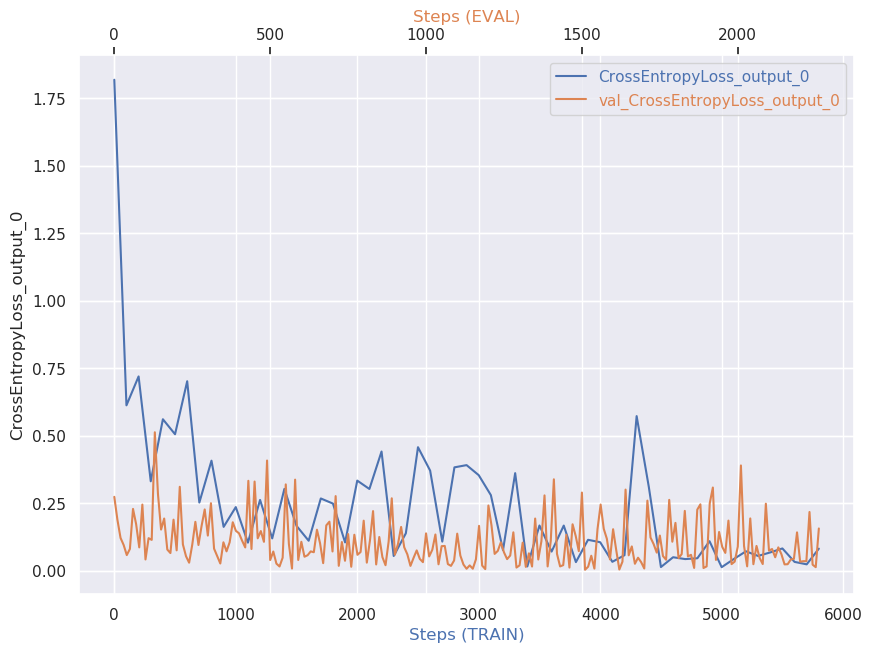

In [ ]:
trial = create_trial(estimator_combined.latest_job_debugger_artifacts_path())

plot_tensor(trial, "CrossEntropyLoss_output_0")

[2023-04-16 15:12:48.971 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionDistinct-2023-04-16-06-34-57-811/debug-output
loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


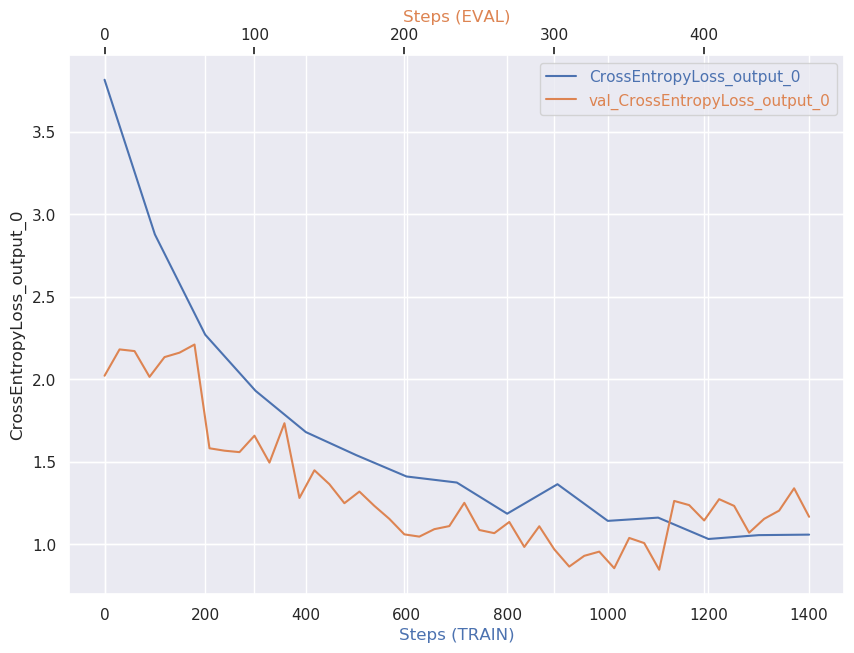

In [ ]:
trial = create_trial(estimator_distinct.latest_job_debugger_artifacts_path())

plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# Display the profiler output
rule_output_path = estimator_combined.output_path + estimator_combined.latest_training_job.job_name + "/rule-output"

! aws s3 cp {rule_output_path} ./final/combined/ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name_combined = [
    rule["RuleConfigurationName"]
    for rule in estimator_combined.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

download: s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionCombined-2023-04-16-01-38-46-208/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to final/combined/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionCombined-2023-04-16-01-38-46-208/rule-output/ProfilerReport/profiler-output/profiler-report.html to final/combined/ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionCombined-2023-04-16-01-38-46-208/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to final/combined/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionCombined-2023-04-16-01-38-46-208/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to final/combined/ProfilerReport/profiler-output/

In [ ]:
rule_output_path = estimator_distinct.output_path + estimator_distinct.latest_training_job.job_name + "/rule-output"

! aws s3 cp {rule_output_path} ./final/distinct/ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name_distinct = [
    rule["RuleConfigurationName"]
    for rule in estimator_distinct.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

download: s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionDistinct-2023-04-16-06-34-57-811/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to final/distinct/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionDistinct-2023-04-16-06-34-57-811/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to final/distinct/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionDistinct-2023-04-16-06-34-57-811/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to final/distinct/ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-478238033619/trafficSignRecognitionDistinct-2023-04-16-06-34-57-811/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to final/distinct/ProfilerReport/profiler-output/profil

In [172]:
import IPython

IPython.display.HTML(filename="./final/combined/ProfilerReport/profiler-output/profiler-report.html")

In [173]:
IPython.display.HTML(filename="./final/distinct/ProfilerReport/profiler-output/profiler-report.html")

In [174]:
import shutil
shutil.make_archive("./final/combined", "zip", "ProfilerReport")

'/root/final/combined.zip'

In [175]:
shutil.make_archive("./final/distinct", "zip", "ProfilerReport")

'/root/final/distinct.zip'

In [176]:
estimator_combined_path = estimator_combined.model_data

In [177]:
estimator_distinct_path = estimator_distinct.model_data

## Model Deploying and Calculating Metrics

In [178]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )


In [179]:
pytorch_model_combined = PyTorchModel(model_data=estimator_combined_path, role=role, entry_point='endpoint_inference_combined.py',py_version='py36',
                             framework_version='1.6',
                             predictor_cls=ImagePredictor)

In [180]:
pytorch_model_base_combined = PyTorchModel(model_data=estimator_base_combined_path, role=role, entry_point='endpoint_inference_combined.py',py_version='py36',
                             framework_version='1.6',
                             predictor_cls=ImagePredictor)

In [181]:
pytorch_model_distinct = PyTorchModel(model_data=estimator_distinct_path, role=role, entry_point='endpoint_inference_distinct.py',py_version='py36',
                             framework_version='1.6',
                             predictor_cls=ImagePredictor)

In [182]:
pytorch_model_base_distinct = PyTorchModel(model_data=estimator_base_distinct_path, role=role, entry_point='endpoint_inference_distinct.py',py_version='py36',
                             framework_version='1.6',
                             predictor_cls=ImagePredictor)

In [200]:
import time

def run_test(image_directory, endpoint):
    test_images = glob(os.path.join(image_directory, "**.png"))
    
    result = {}
    counter = 0
    for image in test_images:
        if counter % 1000 == 0:
            print("Current picture number:  {} Time: {}".format(counter, time.asctime() ))
        file = open(image, "rb")
        img = file.read()
        response = endpoint.predict(img, initial_args={"ContentType":"image/jpeg"})
        result[os.path.basename(image)] = np.argmax(response, 1)[0]
        counter += 1
    return result

test_directory = "./TrafficSignImages/Test/"

Get the labels for each model for the test data by deploying an endpoint with each model and sending the data to it.

In [203]:
predictor_combined=pytorch_model_combined.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge") 

INFO:sagemaker:Creating model with name: pytorch-inference-2023-04-16-15-38-09-398
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-04-16-15-38-10-271
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-04-16-15-38-10-271


----!

In [204]:
labels_combined = run_test(test_directory, predictor_combined)
testing_ground_truth_combined["Label_Combined"] = testing_ground_truth_combined["Path"] .apply(lambda x: labels_combined[x])
testing_ground_truth_combined.to_csv("results_combined.csv")

Current picture number:  0 Time: Sun Apr 16 15:40:42 2023
Current picture number:  1000 Time: Sun Apr 16 15:42:25 2023
Current picture number:  2000 Time: Sun Apr 16 15:44:06 2023
Current picture number:  3000 Time: Sun Apr 16 15:45:48 2023
Current picture number:  4000 Time: Sun Apr 16 15:47:28 2023
Current picture number:  5000 Time: Sun Apr 16 15:49:09 2023
Current picture number:  6000 Time: Sun Apr 16 15:50:53 2023
Current picture number:  7000 Time: Sun Apr 16 15:52:34 2023
Current picture number:  8000 Time: Sun Apr 16 15:54:14 2023
Current picture number:  9000 Time: Sun Apr 16 15:55:53 2023
Current picture number:  10000 Time: Sun Apr 16 15:57:32 2023
Current picture number:  11000 Time: Sun Apr 16 15:59:11 2023
Current picture number:  12000 Time: Sun Apr 16 16:00:50 2023


In [205]:
predictor_combined.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-04-16-15-38-10-271
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-04-16-15-38-10-271


In [206]:
predictor_distinct=pytorch_model_distinct.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge") 

INFO:sagemaker:Creating model with name: pytorch-inference-2023-04-16-16-02-02-804
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-04-16-16-02-03-614
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-04-16-16-02-03-614


----!

In [207]:
labels_distinct = run_test(test_directory, predictor_distinct)
testing_ground_truth_distinct["Label_Distinct"] = testing_ground_truth_distinct["Path"] .apply(lambda x: labels_distinct[x])
testing_ground_truth_distinct.to_csv("results_distinct.csv")

Current picture number:  0 Time: Sun Apr 16 16:04:35 2023
Current picture number:  1000 Time: Sun Apr 16 16:06:09 2023
Current picture number:  2000 Time: Sun Apr 16 16:07:40 2023
Current picture number:  3000 Time: Sun Apr 16 16:09:10 2023
Current picture number:  4000 Time: Sun Apr 16 16:10:40 2023
Current picture number:  5000 Time: Sun Apr 16 16:12:08 2023
Current picture number:  6000 Time: Sun Apr 16 16:13:39 2023
Current picture number:  7000 Time: Sun Apr 16 16:15:09 2023
Current picture number:  8000 Time: Sun Apr 16 16:16:38 2023
Current picture number:  9000 Time: Sun Apr 16 16:18:06 2023
Current picture number:  10000 Time: Sun Apr 16 16:19:34 2023
Current picture number:  11000 Time: Sun Apr 16 16:21:03 2023
Current picture number:  12000 Time: Sun Apr 16 16:22:31 2023


In [208]:
predictor_distinct.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-04-16-16-02-03-614
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-04-16-16-02-03-614


In [209]:
predictor_base_combined=pytorch_model_base_combined.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge") 

INFO:sagemaker:Creating model with name: pytorch-inference-2023-04-16-16-23-36-828
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-04-16-16-23-37-578
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-04-16-16-23-37-578


----!

In [210]:
labels_base_combined = run_test(test_directory, predictor_base_combined)
testing_ground_truth_combined["Label_Base_Combined"] = testing_ground_truth_combined["Path"] .apply(lambda x: labels_base_combined[x])
testing_ground_truth_combined.to_csv("results_combined.csv")

Current picture number:  0 Time: Sun Apr 16 16:26:09 2023
Current picture number:  1000 Time: Sun Apr 16 16:27:48 2023
Current picture number:  2000 Time: Sun Apr 16 16:29:23 2023
Current picture number:  3000 Time: Sun Apr 16 16:30:57 2023
Current picture number:  4000 Time: Sun Apr 16 16:32:32 2023
Current picture number:  5000 Time: Sun Apr 16 16:34:08 2023
Current picture number:  6000 Time: Sun Apr 16 16:35:45 2023
Current picture number:  7000 Time: Sun Apr 16 16:37:20 2023
Current picture number:  8000 Time: Sun Apr 16 16:38:55 2023
Current picture number:  9000 Time: Sun Apr 16 16:40:29 2023
Current picture number:  10000 Time: Sun Apr 16 16:42:02 2023
Current picture number:  11000 Time: Sun Apr 16 16:43:34 2023
Current picture number:  12000 Time: Sun Apr 16 16:45:07 2023


In [211]:
predictor_base_combined.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-04-16-16-23-37-578
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-04-16-16-23-37-578


In [212]:
predictor_base_distinct=pytorch_model_base_distinct.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge") 

INFO:sagemaker:Creating model with name: pytorch-inference-2023-04-16-16-46-15-484
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-04-16-16-46-16-363
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-04-16-16-46-16-363


-----!

In [213]:
labels_base_distinct = run_test(test_directory, predictor_base_distinct)
testing_ground_truth_distinct["Label_Base_Distinct"] = testing_ground_truth_distinct["Path"] .apply(lambda x: labels_base_distinct[x])
testing_ground_truth_distinct.to_csv("results_distinct.csv")

Current picture number:  0 Time: Sun Apr 16 16:49:18 2023
Current picture number:  1000 Time: Sun Apr 16 16:50:53 2023
Current picture number:  2000 Time: Sun Apr 16 16:52:25 2023
Current picture number:  3000 Time: Sun Apr 16 16:53:56 2023
Current picture number:  4000 Time: Sun Apr 16 16:55:27 2023
Current picture number:  5000 Time: Sun Apr 16 16:56:58 2023
Current picture number:  6000 Time: Sun Apr 16 16:58:30 2023
Current picture number:  7000 Time: Sun Apr 16 17:00:01 2023
Current picture number:  8000 Time: Sun Apr 16 17:01:31 2023
Current picture number:  9000 Time: Sun Apr 16 17:03:01 2023
Current picture number:  10000 Time: Sun Apr 16 17:04:32 2023
Current picture number:  11000 Time: Sun Apr 16 17:06:02 2023
Current picture number:  12000 Time: Sun Apr 16 17:07:33 2023


In [214]:
predictor_base_distinct.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-04-16-16-46-16-363
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-04-16-16-46-16-363


In [217]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

def print_confusion_matrix(y_truth, y_pred, label_enc):
    cm = confusion_matrix(y_truth, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = label_enc.classes_)
    fig, ax = plt.subplots(figsize=(10,10))
    display.plot(ax=ax, xticks_rotation='vertical')
    plt.show()

In [218]:
# Create label encoders for later use in the confusion matrix for mapping from class to class name
combined_classes = {'Classes': list(classes_combined.values())}
df_combined_classes = pd.DataFrame(data=combined_classes)
label_enc_comb = LabelEncoder()
label_enc_comb.fit(df_combined_classes['Classes'])

LabelEncoder()

In [219]:
distinct_classes = {'Classes': list(classes_distinct.values())}
df_distinct_classes = pd.DataFrame(data=distinct_classes)
label_enc_dist = LabelEncoder()
label_enc_dist.fit(df_distinct_classes['Classes'])

LabelEncoder()

Calculate the specified metrics and create the confusion matrix for each model.

In [220]:
calc_accuracy(testing_ground_truth_combined["ClassId"], testing_ground_truth_combined["Label_Base_Combined"])

0.5954869358669834

In [221]:
calc_accuracy(testing_ground_truth_combined["ClassId"], testing_ground_truth_combined["Label_Combined"])

0.9642121931908155

In [222]:
calc_accuracy(testing_ground_truth_distinct["ClassId"], testing_ground_truth_distinct["Label_Base_Distinct"])

0.2135391923990499

In [223]:
calc_accuracy(testing_ground_truth_distinct["ClassId"], testing_ground_truth_distinct["Label_Distinct"])

0.6255740300870942

In [226]:
calc_acc_per_class(testing_ground_truth_combined["ClassId"], testing_ground_truth_combined["Label_Base_Combined"])

array([0.99640288, 0.        , 0.        , 0.29943503, 0.97383513,
       0.06296296])

In [227]:
calc_acc_per_class(testing_ground_truth_combined["ClassId"], testing_ground_truth_combined["Label_Combined"])

array([0.97745803, 0.92484848, 0.81666667, 0.98418079, 0.99032258,
       0.94021164])

In [228]:
calc_acc_per_class(testing_ground_truth_distinct["ClassId"], testing_ground_truth_distinct["Label_Base_Distinct"])

array([0.        , 0.35277778, 0.59866667, 0.        , 0.        ,
       0.        , 0.        , 0.02444444, 0.        , 0.        ,
       0.56818182, 0.12142857, 0.67246377, 0.6       , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.95797101, 0.        ,
       0.        , 0.        , 0.        ])

In [229]:
calc_acc_per_class(testing_ground_truth_distinct["ClassId"], testing_ground_truth_distinct["Label_Distinct"])

array([0.        , 0.92638889, 0.30666667, 0.21777778, 0.68181818,
       0.59365079, 0.7       , 0.67333333, 0.47333333, 0.56875   ,
       0.88181818, 0.78571429, 0.89710145, 0.97222222, 0.87407407,
       0.9047619 , 0.52      , 0.85277778, 0.65897436, 0.08333333,
       0.02222222, 0.03333333, 0.18333333, 0.32666667, 0.        ,
       0.55208333, 0.57777778, 0.03333333, 0.2       , 0.05555556,
       0.12      , 0.8037037 , 0.73333333, 0.49047619, 0.35833333,
       0.6025641 , 0.29166667, 0.05      , 0.93188406, 0.        ,
       0.46666667, 0.01666667, 0.2       ])

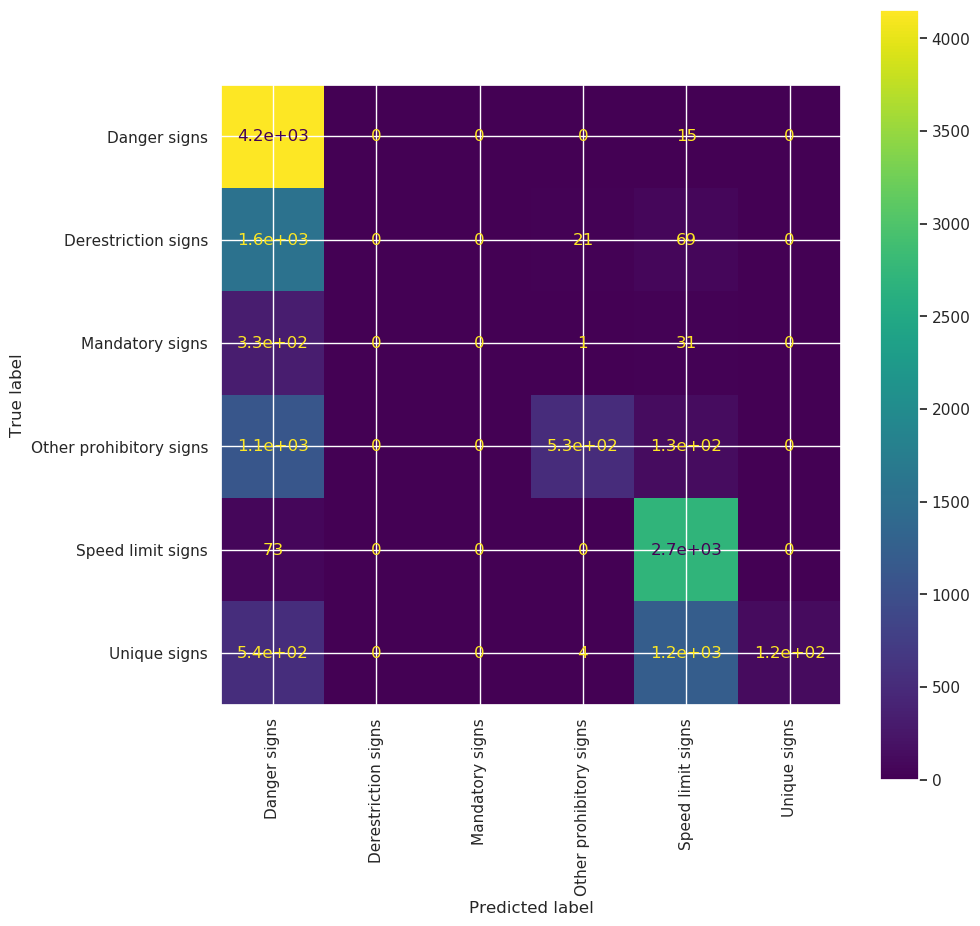

In [231]:
print_confusion_matrix(testing_ground_truth_combined["ClassId"], testing_ground_truth_combined["Label_Base_Combined"], label_enc_comb)

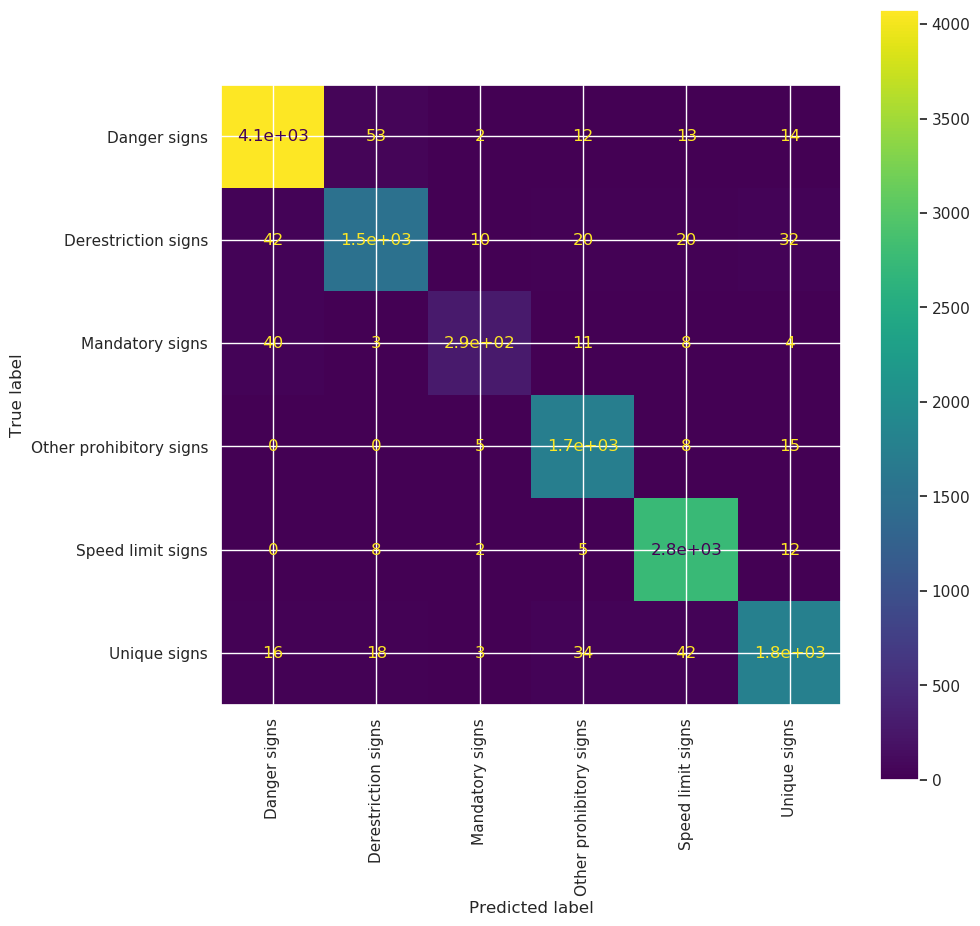

In [232]:
print_confusion_matrix(testing_ground_truth_combined["ClassId"], testing_ground_truth_combined["Label_Combined"], label_enc_comb)

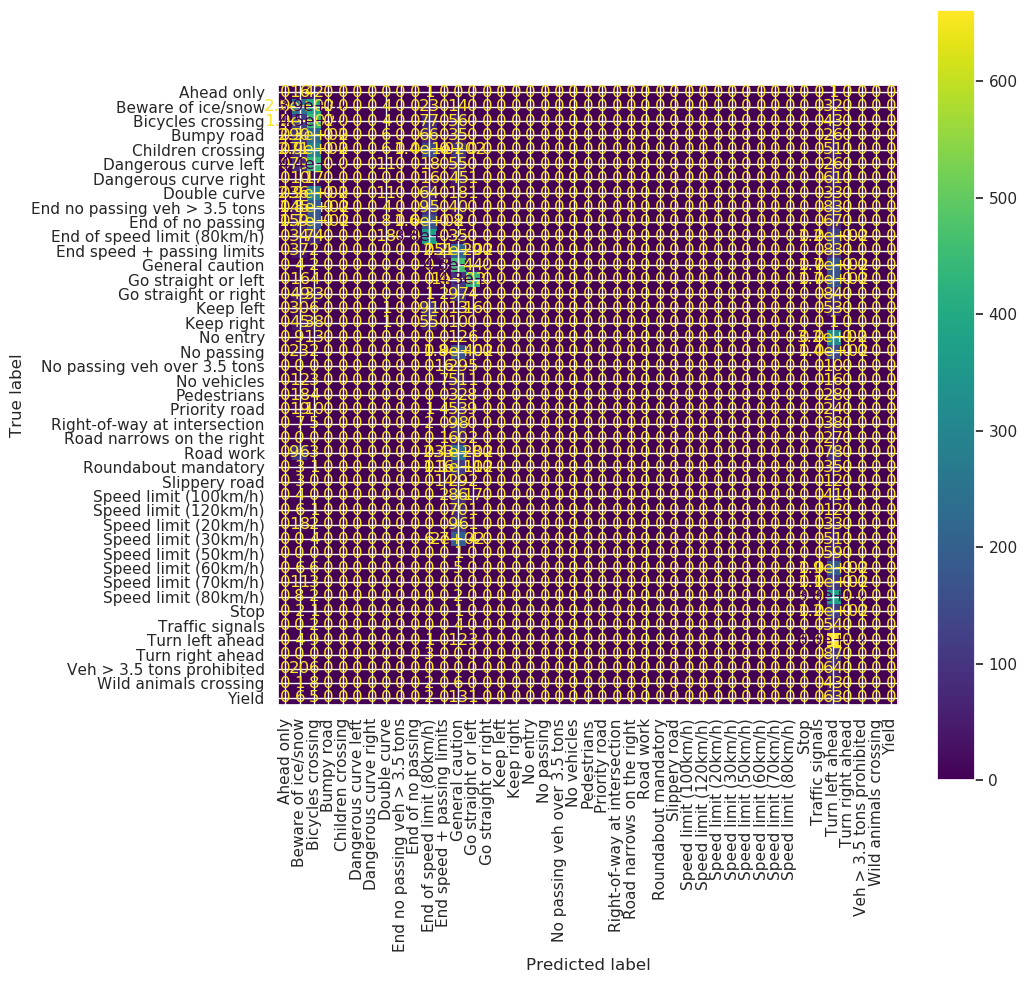

In [233]:
print_confusion_matrix(testing_ground_truth_distinct["ClassId"], testing_ground_truth_distinct["Label_Base_Distinct"], label_enc_dist)

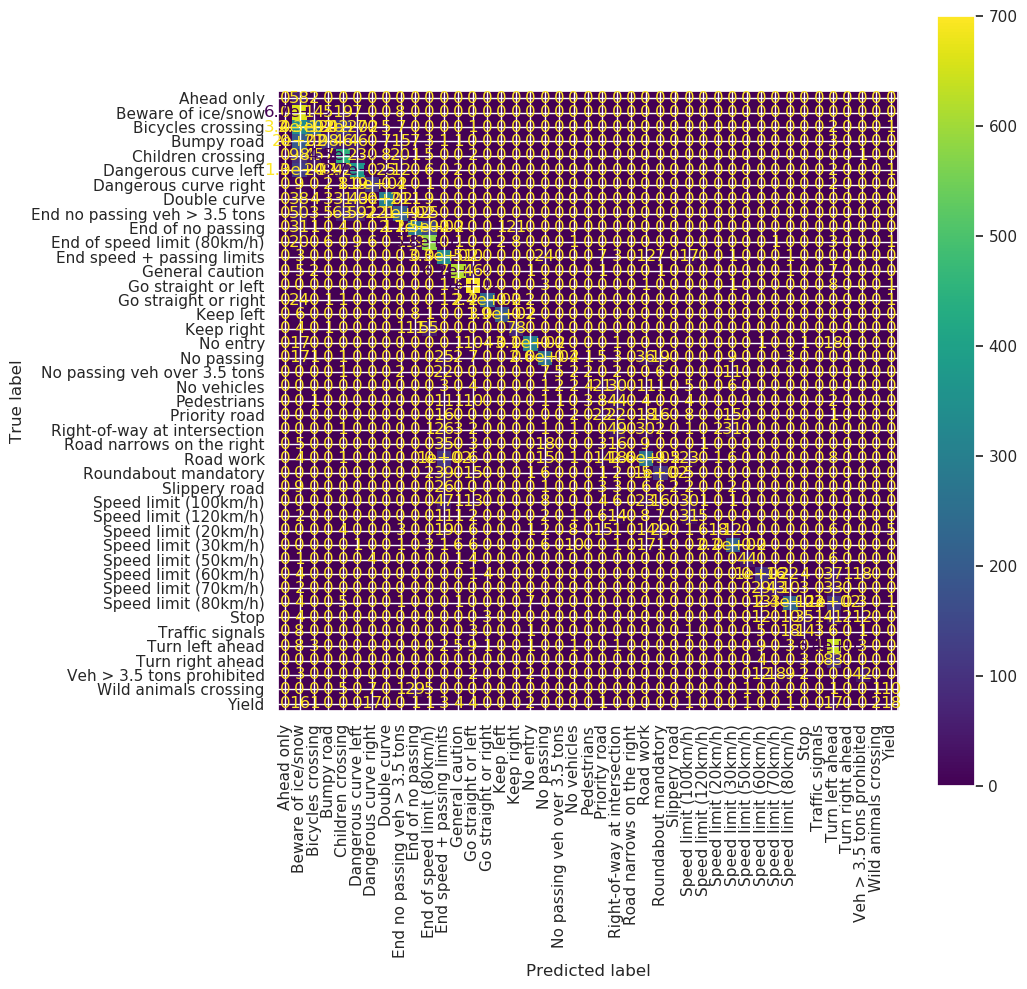

In [234]:
print_confusion_matrix(testing_ground_truth_distinct["ClassId"], testing_ground_truth_distinct["Label_Distinct"], label_enc_dist)